In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

u_unique = ratings.userId.unique()
user2Idx = {o:i for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i for i,o in enumerate(m_unique)}

In [4]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [5]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [6]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1663


In [7]:
from keras.layers import Input, Embedding, Flatten, Dropout, Concatenate, Dense
from keras import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

In [9]:
movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = Dropout(0.2)(movie_vec)


user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
                                                  n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = Dropout(0.2)(user_vec)


concat = Concatenate(name='Concat')([movie_vec, user_vec])
concat = Dropout(0.2)(concat)
dense = Dense(200,name='FullyConnected')(concat)
dropout_1 = Dropout(0.2,name='Dropout')(dense)
dense_2 = Dense(100,name='FullyConnected-1')(concat)
dropout_2 = Dropout(0.2,name='Dropout')(dense_2)
dense_3 = Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = Dropout(0.2,name='Dropout')(dense_3)
dense_4 = Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = Dense(1, activation='relu',name='Activation')(dense_4)
model = Model([user_input, movie_input], result)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [20]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [21]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [22]:
adam = Adam(lr=0.001)
model.compile(optimizer=adam,loss= 'mean_squared_error', metrics=[root_mean_squared_error])

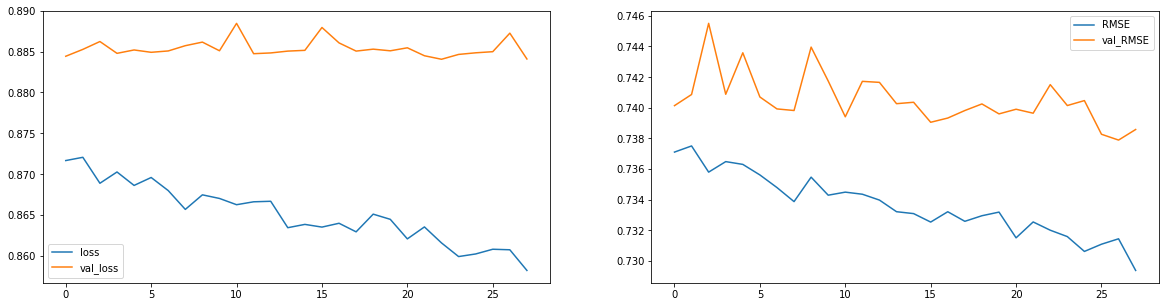

Epoch 29/100
78080/80000 [============================>.] - ETA: 0s - loss: 0.8583 - root_mean_squared_error: 0.7299

KeyboardInterrupt: 

In [23]:
history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    batch_size = 320,
                    callbacks = [plot_losses],
                    epochs=100, verbose=1)